In [1]:
import tensorflow as tf
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
import evaluate
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader
from transformers import  pipeline, SegformerFeatureExtractor, SegformerForSemanticSegmentation, SegformerConfig
from transformers.image_transforms import rgb_to_id
from huggingface_hub import notebook_login
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from datasets import load_metric
import torch
import torch.nn as nn
import logging
import torchvision
from torchvision.datasets import Cityscapes
from torchvision.transforms import ToTensor, ColorJitter
from torch.utils.tensorboard import SummaryWriter

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations
INFO:datasets:PyTorch version 2.3.0+cu118 available.
INFO:datasets:TensorFlow version 2.16.1 available.


In [2]:
root_dir = "data"
print(torch.cuda.is_available())  
print(torch.cuda.device_count())  
print(torch.cuda.get_device_name(0)) 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

True
1
NVIDIA GeForce RTX 4060 Ti
Using device: cuda


In [3]:
class SemanticSegmentationDataset(TorchDataset):
    """
    Data generator for Cityscapes dataset, used for training models.
    """
    def __init__(
        self,
        root_dir,
        feature_extractor,
        img_size=(256, 256),
        data_cat="train",
        data_augmentation=False,
    ):
        "Initialization"
        self.img_size = img_size
        self.feature_extractor = feature_extractor

        self.img_root = os.path.join(root_dir, f"P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/{data_cat}")
        self.label_root = os.path.join(root_dir, f"P8_Cityscapes_gtFine_trainvaltest/gtFine/{data_cat}")

        # Create full paths for images and labels
        cities = os.listdir(self.img_root)
        self.list_IDs = []  # List of image paths
        self.labels = {}  # Dictionary to store labels against image paths
        self.id2label = {}
        self.label2id = {}

        for city in cities:
            img_dir = os.path.join(self.img_root, city)
            label_dir = os.path.join(self.label_root, city)

            img_names = sorted([name for name in os.listdir(img_dir) if "_leftImg8bit.png" in name])
            label_names = sorted([name.replace("_leftImg8bit.png", "_gtFine_labelIds.png") for name in img_names])

            self.list_IDs.extend([os.path.join(img_dir, name) for name in img_names])
            for i, name in enumerate(img_names):
                self.labels[os.path.join(img_dir, name)] = os.path.join(label_dir, label_names[i])

        assert len(self.list_IDs) == len(self.labels)

        self.categories = {
            "void": [0, 1, 2, 3, 4, 5, 6],
            "flat": [7, 8, 9, 10],
            "construction": [11, 12, 13, 14, 15, 16],
            "object": [17, 18, 19, 20],
            "nature": [21, 22],
            "sky": [23],
            "human": [24, 25],
            "vehicle": [26, 27, 28, 29, 30, 31, 32, 33, -1],
        }
        
        for i, (category, _) in enumerate(self.categories.items()):
            self.id2label[i] = category
            self.label2id[category] = i 

        self.data_augmentation = data_augmentation
        if self.data_augmentation:
            self.augmentor = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
                A.Blur(blur_limit=1, p=0.3),
            ])

    def __len__(self):
        "Denotes the number of samples in the dataset"
        return len(self.list_IDs)

    def __getitem__(self, index, encode=True):
        "Generate one sample of data"
        if isinstance(index, list):
            index = index[0]
        ID = self.list_IDs[index]
        X, y = self.__data_generation(ID)
        # Preprocess the images and labels using the image processor
        if encode:
            encoded_inputs = self.feature_extractor(X, y, return_tensors="pt")
            
            for k,v in encoded_inputs.items():
                encoded_inputs[k].squeeze_() # remove batch dimension

            return encoded_inputs
        else:
            return X,y

    def __data_generation(self, ID):
        "Generates data for one sample"
        img = Image.open(ID).resize(self.img_size)
        label_img = Image.open(self.labels[ID]).resize(self.img_size, resample=Image.NEAREST)

        if self.data_augmentation:
            augmented = self.augmentor(image=np.array(img), mask=np.array(label_img))
            img = Image.fromarray((augmented["image"]).astype(np.uint8))
            label_img = Image.fromarray(augmented["mask"])

        label = np.array(label_img)
        # Apply label reduction
        reduced_label = np.zeros_like(label)
        for cat_id, (cat_name, cat_ids) in enumerate(self.categories.items()):
            for id_ in cat_ids:
                reduced_label[label == id_] = cat_id

        return np.array(img), reduced_label


In [10]:
checkpoint = "nvidia/segformer-b2-finetuned-cityscapes-1024-1024"
feature_extractor = SegformerFeatureExtractor.from_pretrained(checkpoint)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir,  feature_extractor=feature_extractor, data_augmentation=False)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, data_cat='val')
aug_train_dataset = SemanticSegmentationDataset(root_dir=root_dir,  feature_extractor=feature_extractor, data_augmentation=True)

c:\Users\aurel\Documents\Master\Developpez une preuve de concept\.venv\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
c:\Users\aurel\Documents\Master\Developpez une preuve de concept\.venv\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(
c:\Users\aurel\Documents\Master\Developpez une preuve de concept\.venv\lib\site-packages\pydantic\main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expect

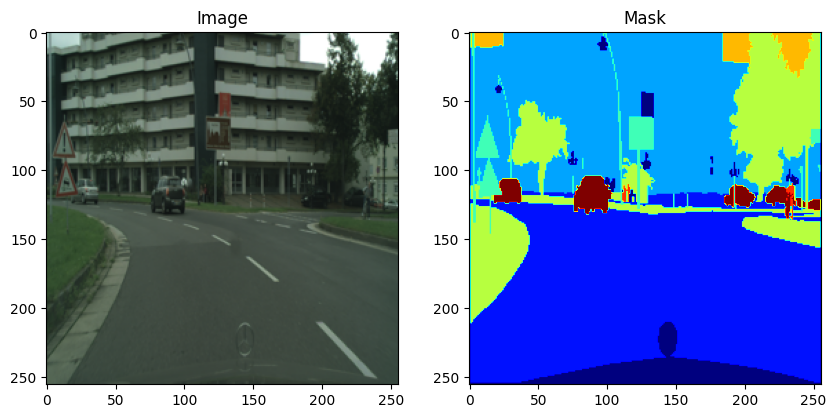

In [65]:
img, label = train_dataset.__getitem__(0, encode=False)
img = Image.fromarray(img)
def plot_img_mask(img, label):
    """
    Cette fonction récupère le premier lot du générateur fourni, extrait la première image et son masque 
    correspondant, et affiche l'image et le masque côte à côte pour comparaison.

    Args:
        generator (tf.keras.utils.Sequence): Générateur fournissant des lots d'images et de masques.
    """
    
    plt.figure(figsize=(10, 5))

    # Afficher l'image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Image")

    # Afficher le masque
    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap="jet")
    plt.title("Mask")
    plt.show()


plot_img_mask(img, label)
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))
print("Number of unique label :", train_dataset[0]["labels"].squeeze().unique())

### Utilisation d'un modèle déja fine tuné

In [11]:
def create_cityscapes_label_colormap():
    colormap = np.zeros((256, 3), dtype=np.uint8)
    colormap[0] = [128, 64, 128]
    colormap[1] = [168,28,52]
    colormap[2] = [16,18,112]
    colormap[3] = [154, 156, 153]
    colormap[4] = [168,167,18]
    colormap[5] = [80,108,28]
    colormap[6] = [112,164,196]
    colormap[7] = [78,82,110]
    return colormap

def get_label_to_index_mapping():
    return {
        'flat': 0,
        'human': 1,
        'vehicle': 2,
        'construction': 3,
        'object': 4,
        'nature': 5,
        'sky': 6,
        'void': 7
    }

categories = {
    "flat": ["road", "sidewalk", "parking", "rail track"],
    "human": ["person", "rider"],
    "vehicle": ["car", "truck", "bus", "on rails", "motorcycle", "bicycle", "caravan", "trailer"],
    "construction": ["building", "wall", "fence", "guard rail", "bridge", "tunnel"],
    "object": ["pole", "pole group", "traffic sign", "traffic light"],
    "nature": ["vegetation", "terrain"],
    "sky": ["sky"],
    "void": ["ground", "dynamic", "static"]
}

def map_label_to_category(label):
    for category, labels in categories.items():
        if label in labels:
            return category
    return 'void'

def apply_colormap(segmentation_map, colormap):
    colored_map = colormap[segmentation_map]
    return colored_map

def blend_images(original_image, colored_segmentation, alpha=0.6):
    blended_image = Image.blend(original_image, colored_segmentation, alpha)
    return blended_image

c:\Users\aurel\Documents\Master\Developpez une preuve de concept\.venv\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


[{'score': None,
  'label': 'road',
  'mask': <PIL.Image.Image image mode=L size=256x256>},
 {'score': None,
  'label': 'sidewalk',
  'mask': <PIL.Image.Image image mode=L size=256x256>},
 {'score': None,
  'label': 'building',
  'mask': <PIL.Image.Image image mode=L size=256x256>},
 {'score': None,
  'label': 'pole',
  'mask': <PIL.Image.Image image mode=L size=256x256>},
 {'score': None,
  'label': 'traffic sign',
  'mask': <PIL.Image.Image image mode=L size=256x256>},
 {'score': None,
  'label': 'vegetation',
  'mask': <PIL.Image.Image image mode=L size=256x256>},
 {'score': None,
  'label': 'terrain',
  'mask': <PIL.Image.Image image mode=L size=256x256>},
 {'score': None,
  'label': 'sky',
  'mask': <PIL.Image.Image image mode=L size=256x256>},
 {'score': None,
  'label': 'person',
  'mask': <PIL.Image.Image image mode=L size=256x256>},
 {'score': None,
  'label': 'car',
  'mask': <PIL.Image.Image image mode=L size=256x256>}]

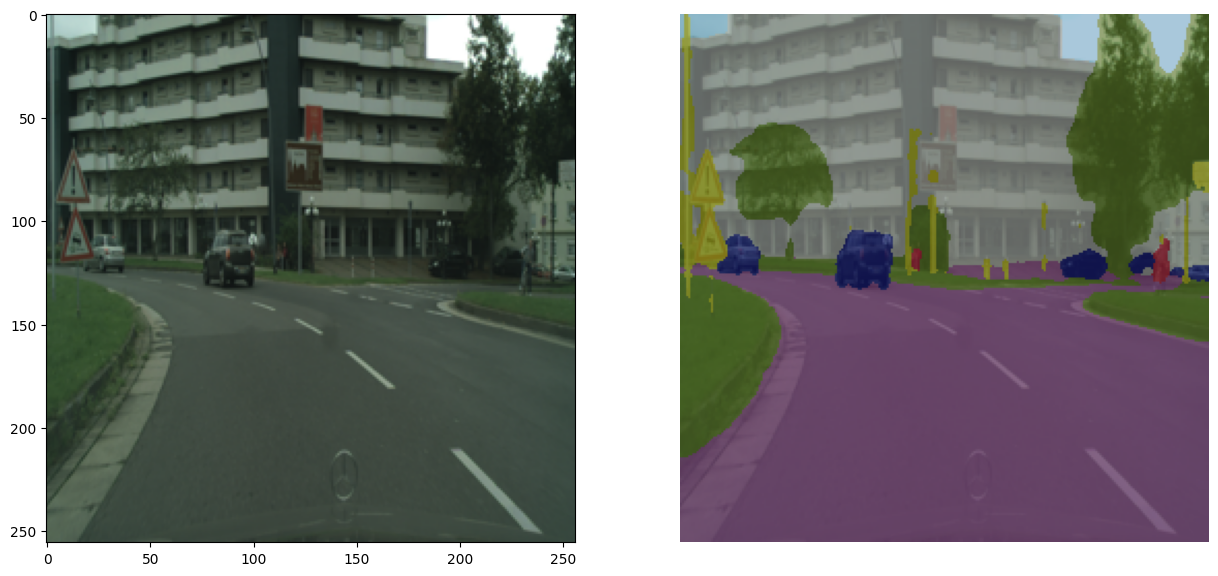

In [66]:
semantic_segmentation = pipeline("image-segmentation", checkpoint)
results = semantic_segmentation(img)
display(results)

# Créer la palette de couleurs et le mapping des labels aux indices
colormap = create_cityscapes_label_colormap()
label_to_index = get_label_to_index_mapping()

# Initialiser la carte de segmentation complète
segmentation_map = np.zeros((img.size[1], img.size[0]), dtype=np.uint8)

# Parcourir chaque segment et appliquer le masque correspondant
for result in results:
    label = result['label']
    category = map_label_to_category(label)
    category_index = label_to_index[category]
    mask = np.array(result['mask'].resize(img.size))
    segmentation_map[mask > 0] = category_index

# Appliquer la palette de couleurs à la carte de segmentation
colored_segmentation = apply_colormap(segmentation_map, colormap)
colored_segmentation_image = Image.fromarray(colored_segmentation.astype(np.uint8))

# Superposer les images
blended_image = blend_images(img, colored_segmentation_image, alpha=0.6)

# Afficher l'image résultante
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(blended_image)
plt.axis('off')
plt.show()



### Segformer : entrainement et evaluation (b2)

In [6]:
def train_one_epoch(model, dataloader, optimizer, device, metric, id2label):
    model = model.to(device)
    model.train()
    train_loss = 0
    for idx, batch in enumerate(tqdm(dataloader, desc="Training")):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)
            metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())
    train_loss /= len(dataloader)
    train_metrics = metric.compute(num_labels=len(id2label), ignore_index=255, reduce_labels=False)
    return train_loss, train_metrics

def validate_one_epoch(model, dataloader, device, metric, id2label):
    model = model.to(device)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(dataloader, desc="Validation")):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)
            metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())
    val_loss /= len(dataloader)
    valid_metrics = metric.compute(num_labels=len(id2label), ignore_index=255, reduce_labels=False)
    return val_loss, valid_metrics

##### Création du modèle

In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained(checkpoint, num_labels=len(train_dataset.id2label), id2label=train_dataset.id2label, label2id=train_dataset.label2id, ignore_mismatched_sizes=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [4]:
#Setup
metric = evaluate.load("mean_iou")
epochs = 20
best_val_loss = float('inf')
patience = 3
patience_counter = 0
best_model_state = None

#### Entrainement sans data augmentation

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8)

writer = SummaryWriter(f'runs/{checkpoint}')
# Training Loop
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}/{epochs}")
    train_loss, train_metrics = train_one_epoch(model, train_dataloader, optimizer, device, metric, train_dataset.id2label)
    val_loss, valid_metrics = validate_one_epoch(model, valid_dataloader, device, metric, train_dataset.id2label)

    print(f"Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}")
    print(f"Train Mean IoU: {train_metrics['mean_iou']:.2f}, Val Mean IoU: {valid_metrics['mean_iou']:.2f}")
    print(f"Train Mean Accuracy: {train_metrics['mean_accuracy']:.2f}, Val Mean Accuracy: {valid_metrics['mean_accuracy']:.2f}")

    # Log metrics to TensorBoard
    writer.add_scalars('Loss', {'Train': train_loss, 'Validation': val_loss}, epoch)
    writer.add_scalars('Mean_IoU', {'Train': train_metrics["mean_iou"], 'Validation': valid_metrics["mean_iou"]}, epoch)
    writer.add_scalars('Mean_Accuracy', {'Train': train_metrics["mean_accuracy"], 'Validation': valid_metrics["mean_accuracy"]}, epoch)

    # Checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
        torch.save(best_model_state, f"runs/{checkpoint}/best_model.pt")
        print(f"New best model saved with validation loss: {best_val_loss:.2f}")
    else:
        patience_counter += 1
        print(f"EarlyStopping counter: {patience_counter} out of {patience}")

    if patience_counter >= patience:
        print("Early stopping")
        break

    # Step the scheduler
    scheduler.step()
    

writer.close()


Epoch: 1/20


Training:   0%|          | 0/372 [00:00<?, ?it/s]c:\Users\aurel\Documents\Master\Developpez une preuve de concept\.venv\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\aurel\Documents\Master\Developpez une preuve de concept\.venv\lib\site-packages\datasets\features\image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
Validation: 100%|██████████| 63/63 [00:52<00:00,  1.21it/s]


Train Loss: 0.54, Val Loss: 0.34
Train Mean IoU: 0.58, Val Mean IoU: 0.67
Train Mean Accuracy: 0.67, Val Mean Accuracy: 0.75
New best model saved with validation loss: 0.34
Epoch: 2/20


Validation: 100%|██████████| 63/63 [00:52<00:00,  1.20it/s]


Train Loss: 0.28, Val Loss: 0.28
Train Mean IoU: 0.72, Val Mean IoU: 0.73
Train Mean Accuracy: 0.80, Val Mean Accuracy: 0.82
New best model saved with validation loss: 0.28
Epoch: 3/20


Validation: 100%|██████████| 63/63 [00:51<00:00,  1.22it/s]


Train Loss: 0.23, Val Loss: 0.26
Train Mean IoU: 0.76, Val Mean IoU: 0.74
Train Mean Accuracy: 0.84, Val Mean Accuracy: 0.83
New best model saved with validation loss: 0.26
Epoch: 4/20


Validation: 100%|██████████| 63/63 [00:56<00:00,  1.11it/s]


Train Loss: 0.20, Val Loss: 0.25
Train Mean IoU: 0.78, Val Mean IoU: 0.75
Train Mean Accuracy: 0.85, Val Mean Accuracy: 0.83
New best model saved with validation loss: 0.25
Epoch: 5/20


Validation: 100%|██████████| 63/63 [00:52<00:00,  1.20it/s]


Train Loss: 0.20, Val Loss: 0.25
Train Mean IoU: 0.78, Val Mean IoU: 0.75
Train Mean Accuracy: 0.85, Val Mean Accuracy: 0.84
New best model saved with validation loss: 0.25
Epoch: 6/20


Validation: 100%|██████████| 63/63 [00:52<00:00,  1.21it/s]


Train Loss: 0.19, Val Loss: 0.25
Train Mean IoU: 0.78, Val Mean IoU: 0.75
Train Mean Accuracy: 0.85, Val Mean Accuracy: 0.84
EarlyStopping counter: 1 out of 3
Epoch: 7/20


Validation: 100%|██████████| 63/63 [00:52<00:00,  1.19it/s]


Train Loss: 0.19, Val Loss: 0.25
Train Mean IoU: 0.78, Val Mean IoU: 0.75
Train Mean Accuracy: 0.86, Val Mean Accuracy: 0.84
EarlyStopping counter: 2 out of 3
Epoch: 8/20


Validation: 100%|██████████| 63/63 [00:53<00:00,  1.19it/s]


Train Loss: 0.19, Val Loss: 0.25
Train Mean IoU: 0.78, Val Mean IoU: 0.75
Train Mean Accuracy: 0.86, Val Mean Accuracy: 0.84
EarlyStopping counter: 3 out of 3
Early stopping


#### Avec data augmentation

In [8]:
aug_train_dataloader = DataLoader(aug_train_dataset, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8)
writer = SummaryWriter(f'runs/{checkpoint}_augmented')

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}/{epochs}")
    train_loss, train_metrics = train_one_epoch(model, aug_train_dataloader, optimizer, device, metric, aug_train_dataset.id2label)
    val_loss, valid_metrics = validate_one_epoch(model, valid_dataloader, device, metric, aug_train_dataset.id2label)

    print(f"Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}")
    print(f"Train Mean IoU: {train_metrics['mean_iou']:.2f}, Val Mean IoU: {valid_metrics['mean_iou']:.2f}")
    print(f"Train Mean Accuracy: {train_metrics['mean_accuracy']:.2f}, Val Mean Accuracy: {valid_metrics['mean_accuracy']:.2f}")

    # Log metrics to TensorBoard
    writer.add_scalars('Loss', {'Train': train_loss, 'Validation': val_loss}, epoch)
    writer.add_scalars('Mean_IoU', {'Train': train_metrics["mean_iou"], 'Validation': valid_metrics["mean_iou"]}, epoch)
    writer.add_scalars('Mean_Accuracy', {'Train': train_metrics["mean_accuracy"], 'Validation': valid_metrics["mean_accuracy"]}, epoch)
    
    # Early Stopping and Checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
        torch.save(best_model_state, f"runs/{checkpoint}_augmented/best_model.pt")
        print(f"New best model saved with validation loss: {best_val_loss:.2f}")
    else:
        patience_counter += 1
        print(f"EarlyStopping counter: {patience_counter} out of {patience}")

    if patience_counter >= patience:
        print("Early stopping")
        break

    # Step the scheduler
    scheduler.step()    

writer.close()


Epoch: 1/20


Validation: 100%|██████████| 63/63 [00:51<00:00,  1.23it/s]


Train Loss: 0.29, Val Loss: 0.29
Train Mean IoU: 0.70, Val Mean IoU: 0.72
Train Mean Accuracy: 0.79, Val Mean Accuracy: 0.81
New best model saved with validation loss: 0.29
Epoch: 2/20


Validation: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]


Train Loss: 0.25, Val Loss: 0.26
Train Mean IoU: 0.74, Val Mean IoU: 0.74
Train Mean Accuracy: 0.82, Val Mean Accuracy: 0.83
New best model saved with validation loss: 0.26
Epoch: 3/20


Validation: 100%|██████████| 63/63 [00:51<00:00,  1.22it/s]


Train Loss: 0.23, Val Loss: 0.26
Train Mean IoU: 0.76, Val Mean IoU: 0.75
Train Mean Accuracy: 0.84, Val Mean Accuracy: 0.84
EarlyStopping counter: 1 out of 3
Epoch: 4/20


Validation: 100%|██████████| 63/63 [00:51<00:00,  1.23it/s]


Train Loss: 0.21, Val Loss: 0.25
Train Mean IoU: 0.77, Val Mean IoU: 0.75
Train Mean Accuracy: 0.85, Val Mean Accuracy: 0.84
New best model saved with validation loss: 0.25
Epoch: 5/20


Validation: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]


Train Loss: 0.20, Val Loss: 0.25
Train Mean IoU: 0.77, Val Mean IoU: 0.75
Train Mean Accuracy: 0.85, Val Mean Accuracy: 0.84
EarlyStopping counter: 1 out of 3
Epoch: 6/20


Validation: 100%|██████████| 63/63 [00:50<00:00,  1.25it/s]


Train Loss: 0.20, Val Loss: 0.25
Train Mean IoU: 0.78, Val Mean IoU: 0.75
Train Mean Accuracy: 0.85, Val Mean Accuracy: 0.84
EarlyStopping counter: 2 out of 3
Epoch: 7/20


Validation: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]


Train Loss: 0.20, Val Loss: 0.25
Train Mean IoU: 0.78, Val Mean IoU: 0.75
Train Mean Accuracy: 0.85, Val Mean Accuracy: 0.84
EarlyStopping counter: 3 out of 3
Early stopping


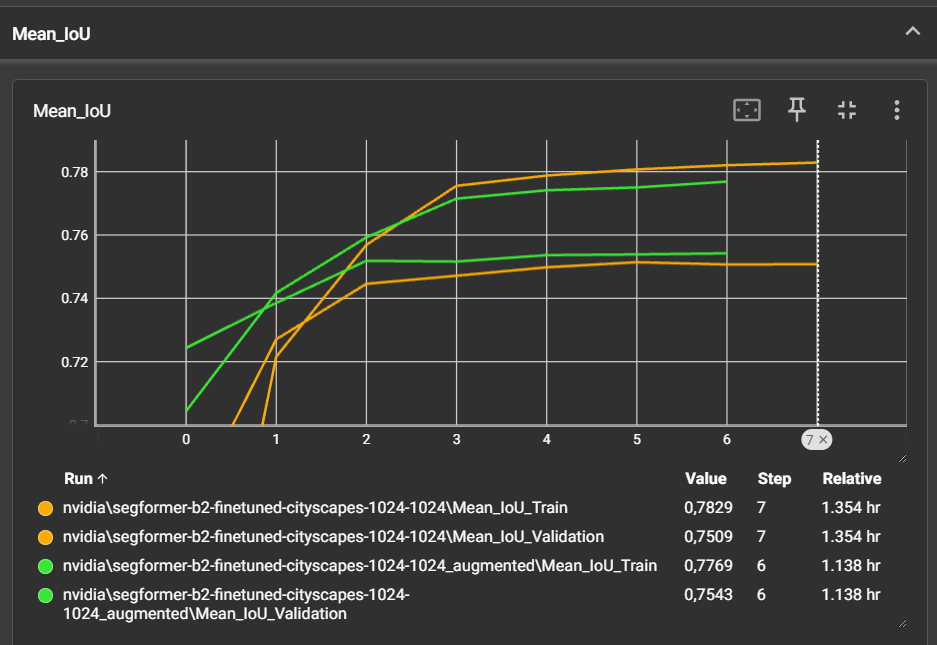

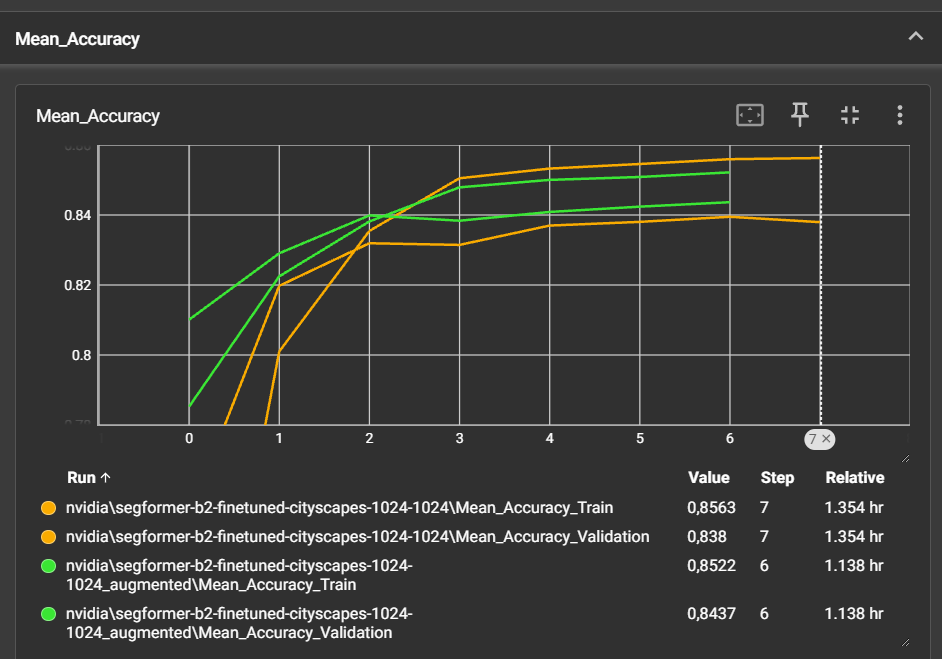

### SegFormer (b4)
#### Avec data augmentation

In [7]:
checkpoint = "nvidia/segformer-b4-finetuned-cityscapes-1024-1024"
feature_extractor = SegformerFeatureExtractor.from_pretrained(checkpoint)

aug_train_dataset = SemanticSegmentationDataset(root_dir=root_dir,  feature_extractor=feature_extractor, data_augmentation=True)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, data_cat='val')
aug_train_dataloader = DataLoader(aug_train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=4)

model = SegformerForSemanticSegmentation.from_pretrained(checkpoint, num_labels=len(aug_train_dataset.id2label), id2label=aug_train_dataset.id2label, label2id=aug_train_dataset.label2id, ignore_mismatched_sizes=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

writer = SummaryWriter(f'runs/{checkpoint}_augmented')

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}/{epochs}")
    train_loss, train_metrics = train_one_epoch(model, aug_train_dataloader, optimizer, device, metric, aug_train_dataset.id2label)
    val_loss, valid_metrics = validate_one_epoch(model, valid_dataloader, device, metric, aug_train_dataset.id2label)

    print(f"Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}")
    print(f"Train Mean IoU: {train_metrics['mean_iou']:.2f}, Val Mean IoU: {valid_metrics['mean_iou']:.2f}")
    print(f"Train Mean Accuracy: {train_metrics['mean_accuracy']:.2f}, Val Mean Accuracy: {valid_metrics['mean_accuracy']:.2f}")

    # Log metrics to TensorBoard
    writer.add_scalars('Loss', {'Train': train_loss, 'Validation': val_loss}, epoch)
    writer.add_scalars('Mean_IoU', {'Train': train_metrics["mean_iou"], 'Validation': valid_metrics["mean_iou"]}, epoch)
    writer.add_scalars('Mean_Accuracy', {'Train': train_metrics["mean_accuracy"], 'Validation': valid_metrics["mean_accuracy"]}, epoch)
    
    # Early Stopping and Checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
        torch.save(best_model_state, f"runs/{checkpoint}_augmented/best_model.pt")
        print(f"New best model saved with validation loss: {best_val_loss:.2f}")
    else:
        patience_counter += 1
        print(f"EarlyStopping counter: {patience_counter} out of {patience}")

    if patience_counter >= patience:
        print("Early stopping")
        break

    # Step the scheduler
    scheduler.step()    

writer.close()


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 768, 1, 1]) in the checkpoint and torch.Size([8, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([19]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1/20


Training:   0%|          | 0/744 [00:00<?, ?it/s]c:\Users\aurel\Documents\Master\Developpez une preuve de concept\.venv\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\aurel\Documents\Master\Developpez une preuve de concept\.venv\lib\site-packages\datasets\features\image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
Validation: 100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


Train Loss: 0.44, Val Loss: 0.27
Train Mean IoU: 0.63, Val Mean IoU: 0.72
Train Mean Accuracy: 0.71, Val Mean Accuracy: 0.81
New best model saved with validation loss: 0.27
Epoch: 2/20


Validation: 100%|██████████| 125/125 [00:58<00:00,  2.12it/s]


Train Loss: 0.23, Val Loss: 0.24
Train Mean IoU: 0.76, Val Mean IoU: 0.75
Train Mean Accuracy: 0.84, Val Mean Accuracy: 0.85
New best model saved with validation loss: 0.24
Epoch: 3/20


Validation: 100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


Train Loss: 0.20, Val Loss: 0.23
Train Mean IoU: 0.78, Val Mean IoU: 0.76
Train Mean Accuracy: 0.85, Val Mean Accuracy: 0.85
New best model saved with validation loss: 0.23
Epoch: 4/20


Validation: 100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


Train Loss: 0.18, Val Loss: 0.23
Train Mean IoU: 0.80, Val Mean IoU: 0.77
Train Mean Accuracy: 0.87, Val Mean Accuracy: 0.85
New best model saved with validation loss: 0.23
Epoch: 5/20


Validation: 100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


Train Loss: 0.17, Val Loss: 0.23
Train Mean IoU: 0.80, Val Mean IoU: 0.77
Train Mean Accuracy: 0.87, Val Mean Accuracy: 0.86
EarlyStopping counter: 1 out of 3
Epoch: 6/20


Validation: 100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


Train Loss: 0.17, Val Loss: 0.23
Train Mean IoU: 0.80, Val Mean IoU: 0.77
Train Mean Accuracy: 0.87, Val Mean Accuracy: 0.86
EarlyStopping counter: 2 out of 3
Epoch: 7/20


Validation: 100%|██████████| 125/125 [00:58<00:00,  2.15it/s]


Train Loss: 0.16, Val Loss: 0.23
Train Mean IoU: 0.80, Val Mean IoU: 0.77
Train Mean Accuracy: 0.87, Val Mean Accuracy: 0.86
EarlyStopping counter: 3 out of 3
Early stopping


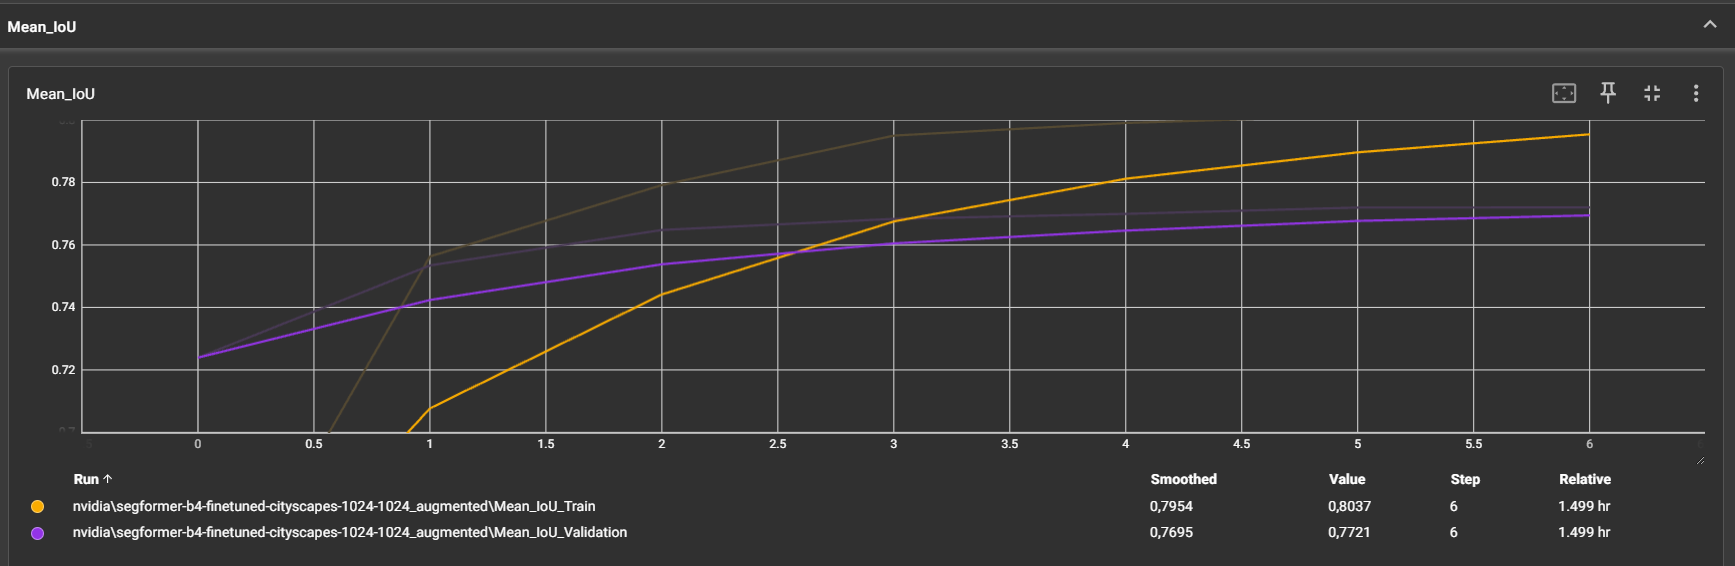

##### Push to Hugging Face

In [8]:
# notebook_login()

# checkpoint = "nvidia/segformer-b4-finetuned-cityscapes-1024-1024"
# state_dict_path = f"runs/{checkpoint}_augmented/best_model.pt"
# model = SegformerForSemanticSegmentation.from_pretrained(checkpoint, num_labels=len(aug_train_dataset.id2label), id2label=aug_train_dataset.id2label, label2id=aug_train_dataset.label2id, ignore_mismatched_sizes=True)
# loaded_state_dict  = torch.load(state_dict_path)
# model.load_state_dict(loaded_state_dict)

    
output_dir = "./segformer_model_b4"
model.save_pretrained(output_dir)
# Push du modèle sur le Hub
model.push_to_hub("Aurel-test/SegFormer_model_b4")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/256M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Aurel-test/SegFormer_model_b4/commit/efeb659b63341c8b9dd49799058fab7ca3680604', commit_message='Upload SegformerForSemanticSegmentation', commit_description='', oid='efeb659b63341c8b9dd49799058fab7ca3680604', pr_url=None, pr_revision=None, pr_num=None)

## Inference

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

img, mask = valid_dataset.__getitem__(10, encode=False)
image = Image.fromarray(img)
mask_array = Image.fromarray(mask)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoding = feature_extractor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)
outputs = model(pixel_values=pixel_values)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]


c:\Users\aurel\Documents\Master\Developpez une preuve de concept\.venv\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


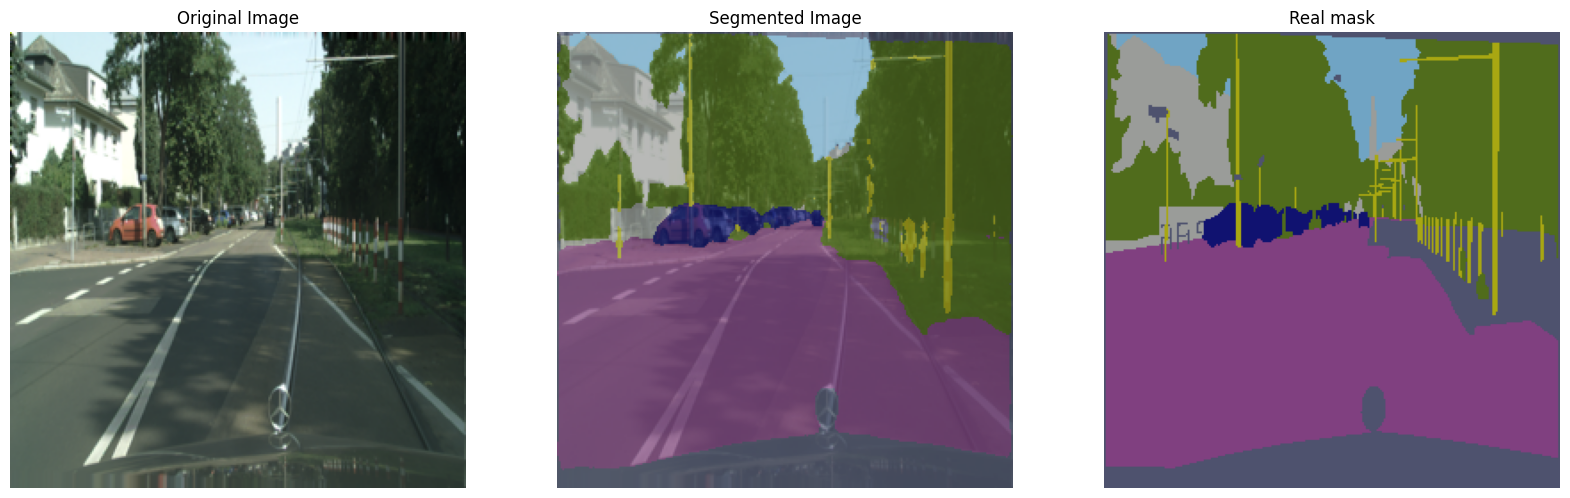

In [12]:
def create_cityscapes_label_colormap():
    colormap = np.zeros((256, 3), dtype=np.uint8)
    colormap[0] = [78,82,110]
    colormap[1] = [128,64,128]
    colormap[2] = [154,156,153]
    colormap[3] = [168,167,18]
    colormap[4] = [80,108,28]
    colormap[5] = [112,164,196]
    colormap[6] = [168,28,52]
    colormap[7] = [16,18,112]
    return colormap


colored_segmentation = apply_colormap(pred_seg, create_cityscapes_label_colormap())
colored_segmentation_image = Image.fromarray(colored_segmentation.astype(np.uint8))
colored_real_mask = apply_colormap(mask_array, create_cityscapes_label_colormap())
colored_real_mask_image = Image.fromarray(colored_real_mask.astype(np.uint8))

blended_image = blend_images(image, colored_segmentation_image, alpha=0.7)


plt.figure(figsize=(20, 15))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(blended_image)
plt.title("Segmented Image")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(colored_real_mask)
plt.title("Real mask")
plt.axis('off')
plt.show()